# Imports

In [1]:
import numpy as np
import glob
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import pandas as pd
import seaborn as sn
sn.set(font_scale=1.4) # for label size
import multiprocessing as mp
import csv

# Load DataSet

0 means unlikely to have flood damage, 1 means likely to have flood damage

[0,1] --> damage

[1,0] --> no damage

## Load Training Set

In [2]:
images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/train_another/damage/*.jpeg')
dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  dmg_img.append(im_arr)
dmg_img = np.array(dmg_img)

images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/train_another/no_damage/*.jpeg')
no_dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  no_dmg_img.append(im_arr)
no_dmg_img = np.array(no_dmg_img)

X_train = np.concatenate((dmg_img, no_dmg_img))
dmg_img_y = np.array(dmg_img.shape[0] * [[0,1]])
no_dmg_img_y = np.array(no_dmg_img.shape[0] * [[1,0]])
y_train = np.concatenate((dmg_img_y, no_dmg_img_y))

# shuffle arrays so that the array is a mix of damage and no_damage in a random order
shuffler = np.random.permutation(X_train.shape[0])
X_train = X_train[shuffler]
y_train = y_train[shuffler]

## Load Validation Set

In [3]:
images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/validation_another/damage/*.jpeg')
dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  dmg_img.append(im_arr)
dmg_img = np.array(dmg_img)

images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/validation_another/no_damage/*.jpeg')
no_dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  no_dmg_img.append(im_arr)
no_dmg_img = np.array(no_dmg_img)

X_val = np.concatenate((dmg_img, no_dmg_img))
dmg_img_y = np.array(dmg_img.shape[0] * [[0,1]])
no_dmg_img_y = np.array(no_dmg_img.shape[0] * [[1,0]])
y_val = np.concatenate((dmg_img_y, no_dmg_img_y))

# shuffle arrays so that the array is a mix of damage and no_damage in a random order
shuffler = np.random.permutation(X_val.shape[0])
X_val = X_val[shuffler]
y_val = y_val[shuffler]

In [4]:
# combine training and validation data - for cross-validation
X_all = np.concatenate((X_train, X_val))
y_all = np.concatenate((y_train, y_val))

## Load Test Set

In [5]:
images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/test/damage/*.jpeg')
dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  dmg_img.append(im_arr)
dmg_img = np.array(dmg_img)

images = glob.glob('/kaggle/input/satellite-images-of-hurricane-damage/test/no_damage/*.jpeg')
no_dmg_img = []
for i in images:
  im = Image.open(i)
  im_arr = np.array(im)
  no_dmg_img.append(im_arr)
no_dmg_img = np.array(no_dmg_img)

X_test = np.concatenate((dmg_img, no_dmg_img))
dmg_img_y = np.array(dmg_img.shape[0] * [[0,1]])
no_dmg_img_y = np.array(no_dmg_img.shape[0] * [[1,0]])
y_test = np.concatenate((dmg_img_y, no_dmg_img_y))

# shuffle arrays so that the array is a mix of damage and no_damage in a random order
shuffler = np.random.permutation(X_val.shape[0])
X_test = X_test[shuffler]
y_test = y_test[shuffler]

# Pre-Process DataSet

In [6]:
# pre-process data 
def scale_pixels(train, val, test, X_all):
	# convert from integers to floats and normalize between 0-1
  train_norm = train.astype('float32') / 255.0
  val_norm = val.astype('float32') / 255.0
  test_norm = test.astype('float32') / 255.0
  X_all_norm = X_all.astype('float32') / 255.0
	# return normalized images
  return train_norm, val_norm, test_norm, X_all_norm

X_train, X_val, X_test, X_all = scale_pixels(X_train, X_val, X_test, X_all)

# Plot Diagnostics

In [7]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
  # blue = training data; orange = validation data
	# plot validation loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='validation')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='validation')

# Create CNN Model

In [8]:
# define cnn model
def define_model(learning_rate):
  model = keras.Sequential()
  model.add(layers.Conv2D(filters=96, input_shape=(128,128,3), kernel_size=(11,11), strides=(4,4), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(4096, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(4096, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(2, activation='softmax'))  # compile model
  opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

## CNN Model with Weight Regularization

In [ ]:
# define cnn model
def define_model_weight_regularization(learning_rate):
  model = keras.Sequential()
  model.add(layers.Conv2D(filters=96, input_shape=(128,128,3), kernel_size=(11,11), strides=(4,4), activation='relu', kernel_regularizer=regularizers.l2(0.01), padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l2(0.01), padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l2(0.01), padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l2(0.01), padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l2(0.01), padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(2, activation='softmax'))  # compile model
  opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

# Train Data
Hyperparameters are inputted into the function

In [9]:
def train(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model(learning_rate)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=10, verbose=1)
  # fit model
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [ ]:
model_test, accuracy = train(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 75)
print(accuracy)
y_pred = model_test.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

Epoch 1/75
157/157 [==============================] - 352s 2s/step - loss: 0.9527 - accuracy: 0.5400 - val_loss: 0.6952 - val_accuracy: 0.5000
Epoch 2/75
157/157 [==============================] - 351s 2s/step - loss: 0.8067 - accuracy: 0.6535 - val_loss: 0.7039 - val_accuracy: 0.5000
Epoch 3/75
157/157 [==============================] - 349s 2s/step - loss: 0.7158 - accuracy: 0.7112 - val_loss: 0.7410 - val_accuracy: 0.5065
Epoch 4/75
157/157 [==============================] - 348s 2s/step - loss: 0.6472 - accuracy: 0.7480 - val_loss: 0.5914 - val_accuracy: 0.6400
Epoch 5/75
157/157 [==============================] - 347s 2s/step - loss: 0.6154 - accuracy: 0.7747 - val_loss: 0.4116 - val_accuracy: 0.8270
Epoch 6/75
157/157 [==============================] - 347s 2s/step - loss: 0.5538 - accuracy: 0.7971 - val_loss: 0.3548 - val_accuracy: 0.8685
Epoch 7/75
157/157 [==============================] - 348s 2s/step - loss: 0.5102 - accuracy: 0.8218 - val_loss: 0.3513 - val_accuracy: 0.8710

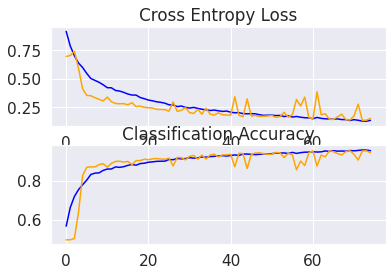

In [11]:
model_test, accuracy = train(X_train, X_val, X_test, y_train, y_val, y_test,1e-5, 75)
print(accuracy)
y_pred = model_test.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

Epoch 1/75
157/157 [==============================] - 322s 2s/step - loss: 1.0637 - accuracy: 0.5274 - val_loss: 0.7132 - val_accuracy: 0.5000
Epoch 2/75
157/157 [==============================] - 318s 2s/step - loss: 0.9711 - accuracy: 0.5607 - val_loss: 0.7183 - val_accuracy: 0.4985
Epoch 3/75
157/157 [==============================] - 317s 2s/step - loss: 0.9307 - accuracy: 0.5814 - val_loss: 0.6910 - val_accuracy: 0.5425
Epoch 4/75
157/157 [==============================] - 317s 2s/step - loss: 0.9001 - accuracy: 0.5990 - val_loss: 0.6417 - val_accuracy: 0.6570
Epoch 5/75
157/157 [==============================] - 317s 2s/step - loss: 0.8938 - accuracy: 0.5951 - val_loss: 0.6018 - val_accuracy: 0.7275
Epoch 6/75
157/157 [==============================] - 317s 2s/step - loss: 0.8565 - accuracy: 0.6249 - val_loss: 0.5778 - val_accuracy: 0.7570
Epoch 7/75
157/157 [==============================] - 317s 2s/step - loss: 0.8476 - accuracy: 0.6333 - val_loss: 0.5641 - val_accuracy: 0.7640

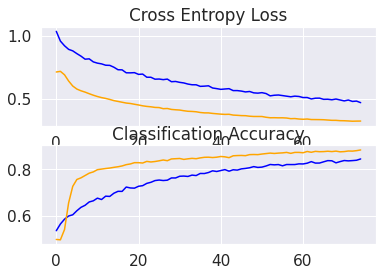

In [13]:
model_test, accuracy = train(X_train, X_val, X_test, y_train, y_val, y_test,1e-6, 75)
print(accuracy)
y_pred = model_test.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

Epoch 1/75
157/157 [==============================] - 271s 2s/step - loss: 0.9053 - accuracy: 0.5770 - val_loss: 0.7527 - val_accuracy: 0.5000
Epoch 2/75
157/157 [==============================] - 269s 2s/step - loss: 0.6006 - accuracy: 0.7702 - val_loss: 1.0503 - val_accuracy: 0.5000
Epoch 3/75
157/157 [==============================] - 271s 2s/step - loss: 0.4618 - accuracy: 0.8423 - val_loss: 1.2126 - val_accuracy: 0.5025
Epoch 4/75
157/157 [==============================] - 273s 2s/step - loss: 0.4199 - accuracy: 0.8603 - val_loss: 0.3649 - val_accuracy: 0.8510
Epoch 5/75
157/157 [==============================] - 274s 2s/step - loss: 0.3789 - accuracy: 0.8712 - val_loss: 0.8468 - val_accuracy: 0.6635
Epoch 6/75
157/157 [==============================] - 274s 2s/step - loss: 0.3335 - accuracy: 0.8843 - val_loss: 0.4954 - val_accuracy: 0.8415
Epoch 7/75
157/157 [==============================] - 271s 2s/step - loss: 0.3174 - accuracy: 0.8849 - val_loss: 0.5953 - val_accuracy: 0.7560

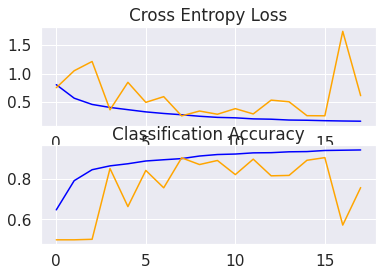

In [10]:
model_test, accuracy = train(X_train, X_val, X_test, y_train, y_val, y_test,5e-5, 75)
print(accuracy)
y_pred = model_test.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

Epoch 1/75
157/157 [==============================] - 328s 2s/step - loss: 0.9562 - accuracy: 0.5727 - val_loss: 0.7259 - val_accuracy: 0.5000
Epoch 2/75
157/157 [==============================] - 325s 2s/step - loss: 0.7177 - accuracy: 0.7180 - val_loss: 0.9653 - val_accuracy: 0.5000
Epoch 3/75
157/157 [==============================] - 323s 2s/step - loss: 0.6020 - accuracy: 0.7714 - val_loss: 1.0673 - val_accuracy: 0.5010
Epoch 4/75
157/157 [==============================] - 322s 2s/step - loss: 0.5465 - accuracy: 0.8064 - val_loss: 0.4955 - val_accuracy: 0.7510
Epoch 5/75
157/157 [==============================] - 322s 2s/step - loss: 0.4877 - accuracy: 0.8393 - val_loss: 0.3453 - val_accuracy: 0.8640
Epoch 6/75
157/157 [==============================] - 322s 2s/step - loss: 0.4531 - accuracy: 0.8440 - val_loss: 0.4788 - val_accuracy: 0.8065
Epoch 7/75
157/157 [==============================] - 322s 2s/step - loss: 0.4203 - accuracy: 0.8617 - val_loss: 0.3329 - val_accuracy: 0.8735

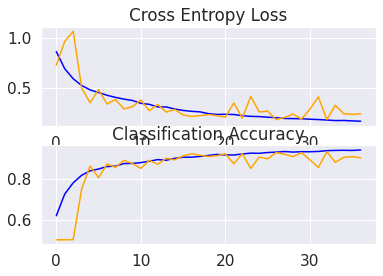

In [10]:
model_test, accuracy = train(X_train, X_val, X_test, y_train, y_val, y_test,2e-5, 75)
print(accuracy)
y_pred = model_test.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

Epoch 1/75
157/157 [==============================] - 322s 2s/step - loss: 0.9911 - accuracy: 0.5274 - val_loss: 0.7042 - val_accuracy: 0.5000
Epoch 2/75
157/157 [==============================] - 322s 2s/step - loss: 0.8454 - accuracy: 0.6186 - val_loss: 0.7598 - val_accuracy: 0.5005
Epoch 3/75
157/157 [==============================] - 321s 2s/step - loss: 0.7703 - accuracy: 0.6871 - val_loss: 0.7430 - val_accuracy: 0.5140
Epoch 4/75
157/157 [==============================] - 321s 2s/step - loss: 0.6957 - accuracy: 0.7175 - val_loss: 0.5349 - val_accuracy: 0.7050
Epoch 5/75
157/157 [==============================] - 320s 2s/step - loss: 0.6455 - accuracy: 0.7490 - val_loss: 0.4212 - val_accuracy: 0.8370
Epoch 6/75
157/157 [==============================] - 321s 2s/step - loss: 0.6227 - accuracy: 0.7646 - val_loss: 0.3957 - val_accuracy: 0.8495
Epoch 7/75
157/157 [==============================] - 320s 2s/step - loss: 0.5707 - accuracy: 0.7883 - val_loss: 0.3720 - val_accuracy: 0.8600

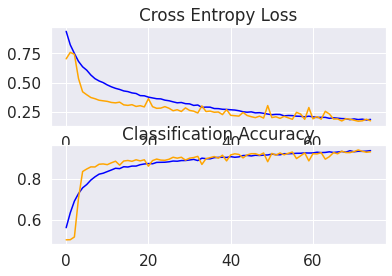

In [10]:
model_test, accuracy = train(X_train, X_val, X_test, y_train, y_val, y_test,7e-6, 75)
print(accuracy)
y_pred = model_test.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

Epoch 1/75
157/157 [==============================] - 326s 2s/step - loss: 1.0304 - accuracy: 0.5064 - val_loss: 0.6883 - val_accuracy: 0.6380
Epoch 2/75
157/157 [==============================] - 322s 2s/step - loss: 0.8420 - accuracy: 0.6355 - val_loss: 0.7253 - val_accuracy: 0.5000
Epoch 3/75
157/157 [==============================] - 319s 2s/step - loss: 0.7486 - accuracy: 0.6924 - val_loss: 0.7355 - val_accuracy: 0.5165
Epoch 4/75
157/157 [==============================] - 318s 2s/step - loss: 0.6998 - accuracy: 0.7229 - val_loss: 0.5603 - val_accuracy: 0.6730
Epoch 5/75
157/157 [==============================] - 321s 2s/step - loss: 0.6334 - accuracy: 0.7601 - val_loss: 0.4040 - val_accuracy: 0.8425
Epoch 6/75
157/157 [==============================] - 320s 2s/step - loss: 0.5827 - accuracy: 0.7892 - val_loss: 0.4106 - val_accuracy: 0.8285
Epoch 7/75
157/157 [==============================] - 325s 2s/step - loss: 0.5436 - accuracy: 0.8085 - val_loss: 0.3472 - val_accuracy: 0.8690

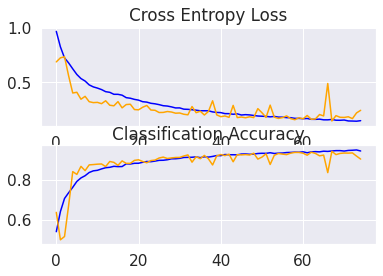

In [10]:
model_test, accuracy = train(X_train, X_val, X_test, y_train, y_val, y_test,9e-6, 75)
print(accuracy)
y_pred = model_test.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

## Train Data with Data Augmentation

In [ ]:
def train_data_augmentation(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model(learning_rate)
  # create data generator
  datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
  # prepare iterator
  it_train = datagen.flow(X_train, y_train, batch_size=64)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=10, verbose=1)
	# fit model
  steps = int(X_train.shape[0] / 64)
  history = model.fit(it_train, epochs=epochs, steps_per_epoch=steps, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [ ]:
model_test_data, accuracy = train_data_augmentation(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 75)
print(accuracy)
y_pred = model_test_data.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

In [ ]:
model_test_data, accuracy = train_data_augmentation(X_train, X_val, X_test, y_train, y_val, y_test, 1e-5, 75)
print(accuracy)
y_pred = model_test_data.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

In [ ]:
model_test_data, accuracy = train_data_augmentation(X_train, X_val, X_test, y_train, y_val, y_test, 1e-5, 75)
print(accuracy)
y_pred = model_test_data.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

In [ ]:
def train_data_augmentation2(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model(learning_rate)
  # create data generator
  datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
  # prepare iterator
  it_train = datagen.flow(X_train, y_train, batch_size=64)
	# fit model
  steps = int(X_train.shape[0] / 64)
  history = model.fit(it_train, epochs=epochs, steps_per_epoch=steps, validation_data=(X_val, y_val), verbose=1)
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [ ]:
model_test_data, accuracy = train_data_augmentation2(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 75)
print(accuracy)
y_pred = model_test_data.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

In [ ]:
model_test_data, accuracy = train_data_augmentation2(X_train, X_val, X_test, y_train, y_val, y_test, 1e-5, 50)
print(accuracy)
y_pred = model_test_data.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

## Train Data with Weight Regularization

In [ ]:
def train_data_weight(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model_weight_regularization(learning_rate)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
  # fit model
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [ ]:
model_test_weight, accuracy = train_data_weight(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 75)
print(accuracy)
y_pred = model_test_weight.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

In [ ]:
y_pred = model_test_weight.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))

### Train Data with Data Augmentation and Weight Regularization 

In [ ]:
def train_data_augmentation_weight(X_train, X_val, X_test, y_train, y_val, y_test, learning_rate, epochs):
  # define model
  model = define_model_weight_regularization(learning_rate)
  # create data generator
  datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
  # prepare iterator
  it_train = datagen.flow(X_train, y_train, batch_size=64)
  # define early stopping
  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', min_delta=0, patience=5, verbose=1)
	# fit model  
  steps = int(X_train.shape[0] / 64)
  history = model.fit(it_train, epochs=epochs, steps_per_epoch=steps, validation_data=(X_val, y_val), verbose=1, callbacks=[es])
  # plot model diagnostics
  summarize_diagnostics(history)
  # evaluate model
  _, accuracy = model.evaluate(X_test, y_test, verbose=1)
  return model, accuracy

In [ ]:
model_test_data_weight, accuracy = train_data_augmentation_weight(X_train, X_val, X_test, y_train, y_val, y_test, 0.001, 75)
print(accuracy)
y_pred = model_test_data_weight.predict(X_test)
y_pred_val = y_pred.argmax(axis=1)
y_test_val = y_test.argmax(axis=1)
tn, fp, fn, tp = confusion_matrix(y_test_val, y_pred_val).ravel()
print("{} {} {} {}".format(tn, fp, fn, tp))
print("TPR/Recall: {}".format(tp/(tp+fn)))
print("TNR/Specificity: {}".format(tn/(tn+fp)))
print("PPV/Precision: {}".format(tp/(tp+fp)))
print("NPV: {}".format(tn/(tn+fn)))